Lo que se desea hacer aca es, que despues de realizar el modelo Random Forest en los raster del Sentinel-2 (Tres Arroyos),
Y haber generado un modelo de RandomForest en este. Y nos de un resultado.
Que como veremos, tendra una buena precisión, pero se va a ver muy granulado en algunas secciones.

Aplicaremos CEWS al resultado de ese modelo de RandomForest x pixel, y ver si suaviza y determina mejor las clases Campo Cultivo, Berbecho y No Agricola

In [ ]:
import numpy as np
import pandas as pd
import rasterio
import time
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from joblib import load, dump

In [31]:
import os

cwd = os.path.abspath(os.getcwd())
print(f"Directorio de trabajo actual: {cwd}")

if os.path.basename(cwd) == 'Joan':
    PROJECT_ROOT = cwd
elif os.path.exists(os.path.join(cwd, 'Joan')):
    PROJECT_ROOT = os.path.join(cwd, 'Joan')
else:
    PROJECT_ROOT = cwd
    print("ADVERTENCIA: No se pudo determinar la carpeta Joan automaticamente")

DATA_PROC_DIR = os.path.join(PROJECT_ROOT, "proc_joan")
RASTER_PATH = os.path.join(PROJECT_ROOT, "11_NDVI_inta_verano.tif")
RASTER_PATH_ABS = os.path.abspath(RASTER_PATH)

print(f"\nConfiguracion de rutas:")
print(f"  PROJECT_ROOT: {PROJECT_ROOT}")
print(f"  DATA_PROC_DIR: {DATA_PROC_DIR}")
print(f"  RASTER_PATH: {RASTER_PATH}")

print(f"\nValidacion de archivos:")
raster_existe = os.path.exists(RASTER_PATH)
proc_dir_existe = os.path.exists(DATA_PROC_DIR)

print(f"  Archivo raster existe: {raster_existe}")
print(f"  Carpeta proc_joan existe: {proc_dir_existe}")

if not raster_existe:
    print(f"\nERROR: No se encontro {RASTER_PATH}")
    print(f"Archivos .tif disponibles en {PROJECT_ROOT}:")
    if os.path.exists(PROJECT_ROOT):
        tif_files = [f for f in os.listdir(PROJECT_ROOT) if f.endswith('.tif')]
        if tif_files:
            for archivo in tif_files:
                print(f"  - {archivo}")
        else:
            print("  (ninguno)")


Directorio de trabajo actual: /Users/joanespada/Desktop/ADE/Recorte&Visualizacion/ade_modelo_agricola/Joan

Configuracion de rutas:
  PROJECT_ROOT: /Users/joanespada/Desktop/ADE/Recorte&Visualizacion/ade_modelo_agricola/Joan
  DATA_PROC_DIR: /Users/joanespada/Desktop/ADE/Recorte&Visualizacion/ade_modelo_agricola/Joan/proc_joan
  RASTER_PATH: /Users/joanespada/Desktop/ADE/Recorte&Visualizacion/ade_modelo_agricola/Joan/11_NDVI_inta_verano.tif

Validacion de archivos:
  Archivo raster existe: True
  Carpeta proc_joan existe: True


## Carga de Datos del Raster

In [32]:
print("="*80)
print("CARGANDO DATOS")
print("="*80)

with rasterio.open(RASTER_PATH) as src:
    categorias_inta = src.read(1)
    
    features_list = []
    for i in range(2, 13):
        banda = src.read(i).astype(np.float32)
        if src.nodata is not None:
            banda[banda == src.nodata] = np.nan
        features_list.append(banda)
    
    X_all = np.stack(features_list, axis=0)
    
    height, width = categorias_inta.shape
    transform = src.transform
    crs = src.crs
    
    print(f"\nDimensiones del raster: {height} x {width}")
    print(f"Numero de features: {X_all.shape[0]}")
    print(f"CRS: {crs}")

n_pixels = height * width
X_all = X_all.reshape(X_all.shape[0], -1).T
categorias_inta_flat = categorias_inta.flatten()

print(f"\nTotal de pixeles: {n_pixels:,}")
print(f"Shape de X: {X_all.shape}")
print(f"Shape de y: {categorias_inta_flat.shape}")

cultivos_agricolas = [10, 11, 12, 18, 26]
barbecho = [21]
no_agricola = [22, 255]

y_agrupado = np.full_like(categorias_inta_flat, -1, dtype=np.int32)

for cat_val in cultivos_agricolas:
    y_agrupado[categorias_inta_flat == cat_val] = 0

y_agrupado[categorias_inta_flat == 21] = 1

for cat_val in no_agricola:
    y_agrupado[categorias_inta_flat == cat_val] = 2

mask_valido = y_agrupado >= 0
X_valido = X_all[mask_valido]
y_valido = y_agrupado[mask_valido]

mask_sin_nan = ~np.any(np.isnan(X_valido), axis=1)
X_clean = X_valido[mask_sin_nan]
y_clean = y_valido[mask_sin_nan]

print(f"\nPixeles validos (con categoria mapeada): {len(X_valido):,}")
print(f"Pixeles validos (sin NaN en features): {len(X_clean):,}")

clases, conteos = np.unique(y_clean, return_counts=True)
nombres_clases = ['CULTIVO AGRICOLA', 'BARBECHO', 'NO AGRICOLA']

print(f"\nDistribucion de clases:")
for clase, conteo, nombre in zip(clases, conteos, nombres_clases):
    porcentaje = 100 * conteo / len(y_clean)
    print(f"  {nombre} (clase {clase}): {conteo:,} pixeles ({porcentaje:.2f}%)")

CARGANDO DATOS

Dimensiones del raster: 2897 x 2798
Numero de features: 11
CRS: EPSG:32721

Total de pixeles: 8,105,806
Shape de X: (8105806, 11)
Shape de y: (8105806,)

Dimensiones del raster: 2897 x 2798
Numero de features: 11
CRS: EPSG:32721

Total de pixeles: 8,105,806
Shape de X: (8105806, 11)
Shape de y: (8105806,)

Pixeles validos (con categoria mapeada): 8,105,806
Pixeles validos (sin NaN en features): 8,104,712

Distribucion de clases:
  CULTIVO AGRICOLA (clase 0): 4,486,080 pixeles (55.35%)
  BARBECHO (clase 1): 1,134,418 pixeles (14.00%)
  NO AGRICOLA (clase 2): 2,484,214 pixeles (30.65%)

Pixeles validos (con categoria mapeada): 8,105,806
Pixeles validos (sin NaN en features): 8,104,712

Distribucion de clases:
  CULTIVO AGRICOLA (clase 0): 4,486,080 pixeles (55.35%)
  BARBECHO (clase 1): 1,134,418 pixeles (14.00%)
  NO AGRICOLA (clase 2): 2,484,214 pixeles (30.65%)


## Validacion Espacial por Bloques

In [12]:
print("="*80)
print("PREPARANDO VALIDACION ESPACIAL")
print("="*80)

indices_validos = np.where(mask_valido)[0]
indices_clean = indices_validos[mask_sin_nan]

filas = indices_clean // width
columnas = indices_clean % width

print(f"Pixeles con coordenadas: {len(filas):,}")

n_bloques_filas = 3
n_bloques_cols = 3
n_bloques_total = n_bloques_filas * n_bloques_cols

tam_bloque_fila = height // n_bloques_filas
tam_bloque_col = width // n_bloques_cols

print(f"\nConfiguracion de bloques:")
print(f"  Bloques: {n_bloques_filas} x {n_bloques_cols} = {n_bloques_total}")
print(f"  Tamaño bloque: ~{tam_bloque_fila} x {tam_bloque_col} pixeles")

bloque_fila = filas // tam_bloque_fila
bloque_col = columnas // tam_bloque_col
bloque_fila = np.clip(bloque_fila, 0, n_bloques_filas - 1)
bloque_col = np.clip(bloque_col, 0, n_bloques_cols - 1)
bloque_id = bloque_fila * n_bloques_cols + bloque_col

bloque_fila_idx = bloque_id // n_bloques_cols
bloque_col_idx = bloque_id % n_bloques_cols
es_train = (bloque_fila_idx + bloque_col_idx) % 2 == 0

train_indices = np.where(es_train)[0]
test_indices = np.where(~es_train)[0]

print(f"\nDivision espacial:")
print(f"  Pixeles entrenamiento: {len(train_indices):,} ({100*len(train_indices)/len(bloque_id):.1f}%)")
print(f"  Pixeles test: {len(test_indices):,} ({100*len(test_indices)/len(bloque_id):.1f}%)")

print(f"\nDistribucion de clases - ENTRENAMIENTO:")
y_train = y_clean[train_indices]
clases_train, conteos_train = np.unique(y_train, return_counts=True)
for clase, conteo in zip(clases_train, conteos_train):
    porcentaje = 100 * conteo / len(y_train)
    print(f"  {nombres_clases[clase]}: {conteo:,} ({porcentaje:.2f}%)")

print(f"\nDistribucion de clases - TEST:")
y_test = y_clean[test_indices]
clases_test, conteos_test = np.unique(y_test, return_counts=True)
for clase, conteo in zip(clases_test, conteos_test):
    porcentaje = 100 * conteo / len(y_test)
    print(f"  {nombres_clases[clase]}: {conteo:,} ({porcentaje:.2f}%)")

X_train = X_clean[train_indices]
X_test = X_clean[test_indices]
y_train = y_clean[train_indices]
y_test = y_clean[test_indices]

print(f"\n[OK] Conjuntos de datos preparados para validacion espacial")

PREPARANDO VALIDACION ESPACIAL
Pixeles con coordenadas: 8,104,712

Configuracion de bloques:
  Bloques: 3 x 3 = 9
  Tamaño bloque: ~965 x 932 pixeles

Division espacial:
  Pixeles entrenamiento: 4,503,913 (55.6%)
  Pixeles test: 3,600,799 (44.4%)

Distribucion de clases - ENTRENAMIENTO:
  CULTIVO AGRICOLA: 2,374,424 (52.72%)
  BARBECHO: 610,004 (13.54%)
  NO AGRICOLA: 1,519,485 (33.74%)

Distribucion de clases - TEST:
  CULTIVO AGRICOLA: 2,111,656 (58.64%)
  BARBECHO: 524,414 (14.56%)
  NO AGRICOLA: 964,729 (26.79%)

Division espacial:
  Pixeles entrenamiento: 4,503,913 (55.6%)
  Pixeles test: 3,600,799 (44.4%)

Distribucion de clases - ENTRENAMIENTO:
  CULTIVO AGRICOLA: 2,374,424 (52.72%)
  BARBECHO: 610,004 (13.54%)
  NO AGRICOLA: 1,519,485 (33.74%)

Distribucion de clases - TEST:
  CULTIVO AGRICOLA: 2,111,656 (58.64%)
  BARBECHO: 524,414 (14.56%)
  NO AGRICOLA: 964,729 (26.79%)

[OK] Conjuntos de datos preparados para validacion espacial

[OK] Conjuntos de datos preparados para vali

## Entrenamiento del Modelo con 50 Estimadores

In [25]:
print("\n" + "="*80)
print("ENTRENANDO Y GUARDANDO MODELO CON 50 ESTIMADORES")
print("="*80)

n_estimators_50 = 50
print(f"\nEntrenando modelo con n_estimators={n_estimators_50}...")
tiempo_inicio_50 = time.time()

rf_model_50 = RandomForestClassifier(
    n_estimators=n_estimators_50,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    oob_score=True,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model_50.fit(X_train, y_train)

tiempo_50 = time.time() - tiempo_inicio_50
print(f"\n[OK] Modelo con 50 estimadores entrenado en {tiempo_50:.1f} segundos")
print(f"OOB Score: {rf_model_50.oob_score_:.4f}")

modelo_path_50 = os.path.join(DATA_PROC_DIR, "11_rf_model_50_estimators.pkl")
print(f"\nGuardando modelo en: {modelo_path_50}")

from joblib import dump as joblib_dump
joblib_dump(rf_model_50, modelo_path_50)
print(f"[OK] Modelo guardado exitosamente")

importancia_features = rf_model_50.feature_importances_
nombres_features = [
    'NDVI_mediana', 'NDVI_min', 'NDVI_max', 'NDVI_sd',
    'NDVI_2023-12', 'NDVI_2024-01', 'NDVI_2024-02', 'NDVI_2024-03',
    'NDVI_2024-04', 'NDVI_2024-05', 'NDVI_2024-06'
]

print("\nImportancia de features (top 5):")
indices_ordenados = np.argsort(importancia_features)[::-1]
for i, idx in enumerate(indices_ordenados[:5]):
    print(f"  {i+1}. {nombres_features[idx]}: {importancia_features[idx]:.4f}")


ENTRENANDO Y GUARDANDO MODELO CON 50 ESTIMADORES

Entrenando modelo con n_estimators=50...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.0min finished



[OK] Modelo con 50 estimadores entrenado en 135.8 segundos
OOB Score: 0.9161

Guardando modelo en: /Users/joanespada/Desktop/ADE/Recorte&Visualizacion/ade_modelo_agricola/data/proc/11_rf_model_50_estimators.pkl
[OK] Modelo guardado exitosamente

Importancia de features (top 5):
  1. NDVI_sd: 0.1471
  2. NDVI_2024-02: 0.1415
  3. NDVI_2023-12: 0.1413
  4. NDVI_2024-03: 0.1263
  5. NDVI_min: 0.1041


## Evaluacion del Modelo

In [26]:
print("="*80)
print("EVALUACION DEL MODELO")
print("="*80)

print("\nGenerando predicciones en conjunto de test...")
tiempo_inicio_pred = time.time()

print("  Prediciendo clases...")
y_pred = rf_model_50.predict(X_test)

tiempo_pred = time.time() - tiempo_inicio_pred
print(f"  [OK] Predicciones completadas en {tiempo_pred:.1f} segundos")

print("  Calculando probabilidades...")
tiempo_inicio_proba = time.time()
y_pred_proba = rf_model_50.predict_proba(X_test)
tiempo_proba = time.time() - tiempo_inicio_proba
print(f"  [OK] Probabilidades calculadas en {tiempo_proba:.1f} segundos")

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print("\n" + "="*80)
print("REPORTE DE CLASIFICACION")
print("="*80)
print(classification_report(y_test, y_pred, target_names=nombres_clases, digits=4))

print("\n" + "="*80)
print("MATRIZ DE CONFUSION")
print("="*80)
cm = confusion_matrix(y_test, y_pred)
print("\nMatriz de confusion (filas=real, columnas=predicho):")
print("                    CULTIVO  BARBECHO  NO_AGRICOLA")
for i, nombre in enumerate(nombres_clases):
    print(f"{nombre:20s} {cm[i, 0]:8d} {cm[i, 1]:8d} {cm[i, 2]:8d}")

print("\nMetricas por clase:")
for i, nombre in enumerate(nombres_clases):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp
    fn = cm[i, :].sum() - tp
    tn = cm.sum() - tp - fp - fn
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f"\n{nombre}:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-score: {f1:.4f}")

EVALUACION DEL MODELO

Generando predicciones en conjunto de test...
  Prediciendo clases...


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


  [OK] Predicciones completadas en 2.2 segundos
  Calculando probabilidades...


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.1s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    2.1s finished


  [OK] Probabilidades calculadas en 2.1 segundos

Accuracy: 0.8624 (86.24%)

REPORTE DE CLASIFICACION
                  precision    recall  f1-score   support

CULTIVO AGRICOLA     0.9019    0.9045    0.9032   2111656
        BARBECHO     0.7918    0.8899    0.8380    524414
     NO AGRICOLA     0.8154    0.7553    0.7842    964729

        accuracy                         0.8624   3600799
       macro avg     0.8364    0.8499    0.8418   3600799
    weighted avg     0.8627    0.8624    0.8618   3600799


MATRIZ DE CONFUSION

Matriz de confusion (filas=real, columnas=predicho):
                    CULTIVO  BARBECHO  NO_AGRICOLA
CULTIVO AGRICOLA      1910035    74006   127615
BARBECHO                20370   466701    37343
NO AGRICOLA            187406    48674   728649

Metricas por clase:

CULTIVO AGRICOLA:
  Precision: 0.9019
  Recall: 0.9045
  F1-score: 0.9032

BARBECHO:
  Precision: 0.7918
  Recall: 0.8899
  F1-score: 0.8380

NO AGRICOLA:
  Precision: 0.8154
  Recall: 0.7553
  F1-

## Generacion del Mapa de Prediccion

GENERANDO MAPAS DE COMPARACION

Prediciendo para todos los pixeles validos...
  Total de pixeles a predecir: 8,104,712


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    4.1s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    6.1s finished
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:    6.1s finished


  [OK] Predicciones completadas en 6.2 segundos (0.1 minutos)


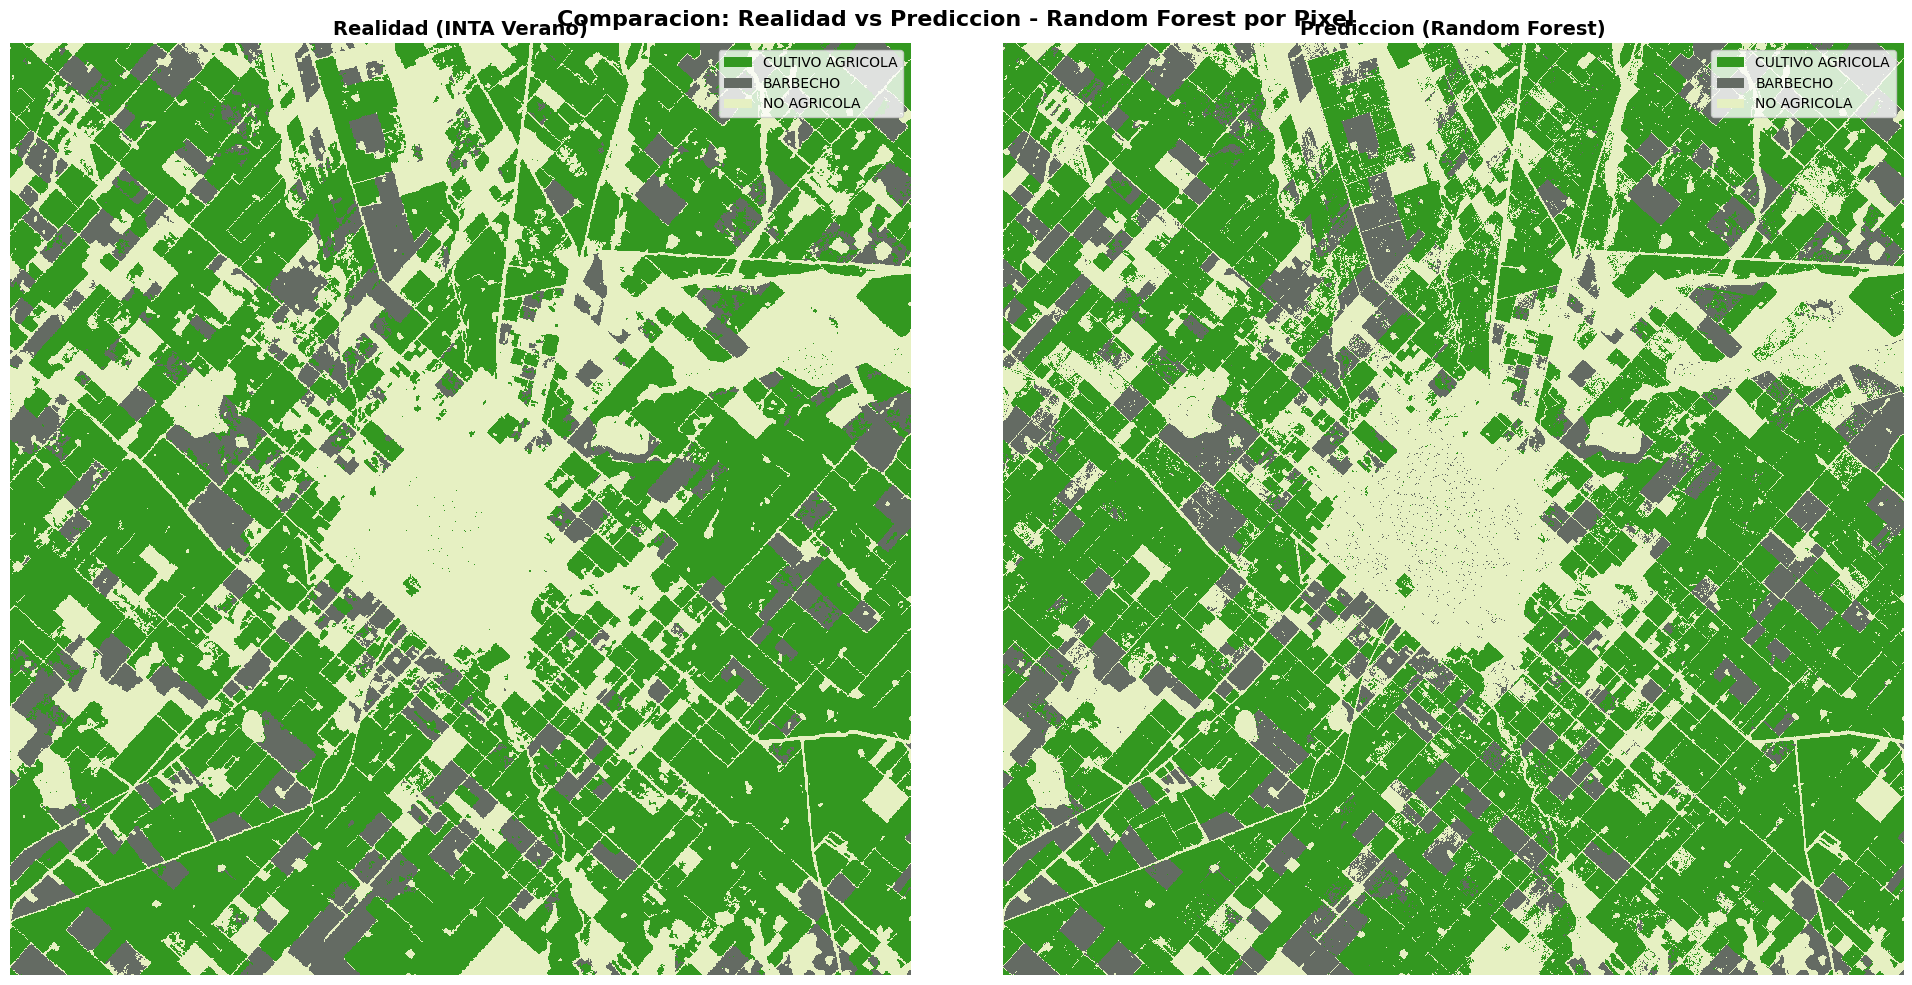


Accuracy espacial (sobre mapa completo): 0.9047 (90.47%)
Pixeles correctos: 7,332,542 de 8,104,712

Guardando mapa de prediccion en: /Users/joanespada/Desktop/ADE/Recorte&Visualizacion/ade_modelo_agricola/Joan/proc_joan/11_prediccion_rf_verano.tif
[OK] Mapa de prediccion guardado


In [33]:
print("="*80)
print("GENERANDO MAPAS DE COMPARACION")
print("="*80)

from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

mapa_realidad = np.full((height, width), -1, dtype=np.int32)
mapa_prediccion = np.full((height, width), -1, dtype=np.int32)

mapa_realidad.flat[indices_clean] = y_clean

print("\nPrediciendo para todos los pixeles validos...")
tiempo_inicio_pred_all = time.time()
n_pixeles_total = len(X_clean)
print(f"  Total de pixeles a predecir: {n_pixeles_total:,}")

y_pred_all = rf_model_50.predict(X_clean)
tiempo_pred_all = time.time() - tiempo_inicio_pred_all
print(f"  [OK] Predicciones completadas en {tiempo_pred_all:.1f} segundos ({tiempo_pred_all/60:.1f} minutos)")

mapa_prediccion.flat[indices_clean] = y_pred_all

fig, axes = plt.subplots(1, 2, figsize=(20, 10))

colores_clases = {
    0: '#339820',
    1: '#646b63',
    2: '#e6f0c2'
}

cmap_custom = ListedColormap([colores_clases[0], colores_clases[1], colores_clases[2]])

ax1 = axes[0]
im1 = ax1.imshow(mapa_realidad, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax1.set_title('Realidad (INTA Verano)', fontsize=14, fontweight='bold')
ax1.axis('off')

handles = [Patch(facecolor=colores_clases[i], label=nombres_clases[i]) for i in range(3)]
ax1.legend(handles=handles, loc='upper right', fontsize=10)

ax2 = axes[1]
im2 = ax2.imshow(mapa_prediccion, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax2.set_title('Prediccion (Random Forest)', fontsize=14, fontweight='bold')
ax2.axis('off')
ax2.legend(handles=handles, loc='upper right', fontsize=10)

plt.suptitle('Comparacion: Realidad vs Prediccion - Random Forest por Pixel', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

mask_comparacion = mapa_realidad >= 0
aciertos = (mapa_realidad[mask_comparacion] == mapa_prediccion[mask_comparacion]).sum()
total_comparacion = mask_comparacion.sum()
accuracy_espacial = aciertos / total_comparacion

print(f"\nAccuracy espacial (sobre mapa completo): {accuracy_espacial:.4f} ({accuracy_espacial*100:.2f}%)")
print(f"Pixeles correctos: {aciertos:,} de {total_comparacion:,}")

output_pred_path = os.path.join(DATA_PROC_DIR, "11_prediccion_rf_verano.tif")
print(f"\nGuardando mapa de prediccion en: {output_pred_path}")

with rasterio.open(RASTER_PATH) as src:
    meta = src.meta.copy()
    meta.update({
        'count': 1,
        'dtype': 'int32',
        'nodata': -1
    })
    
    with rasterio.open(output_pred_path, 'w', **meta) as dst:
        dst.write(mapa_prediccion, 1)
        dst.set_band_description(1, 'Prediccion_RF_Verano')

print("[OK] Mapa de prediccion guardado")

## Aplicacion de Algoritmos de Suavizacion: Canny y Watershed

En esta seccion aplicaremos el algoritmo de deteccion de bordes Canny y el algoritmo de Watershed al mapa de prediccion del Random Forest para suavizar la granularidad y mejorar la segmentacion de los segmentos.

APLICANDO CEWS: CANNY EDGE DETECTION + WATERSHED

1. Normalizando mapa de prediccion para Canny...
2. Aplicando Canny Edge Detection...
3. Aplicando operaciones morfologicas (cierre y apertura)...
4. Aplicando Watershed...
   Segmentos identificados: 3160
5. Remapeando segmentos a clases originales...
[OK] CEWS aplicado exitosamente


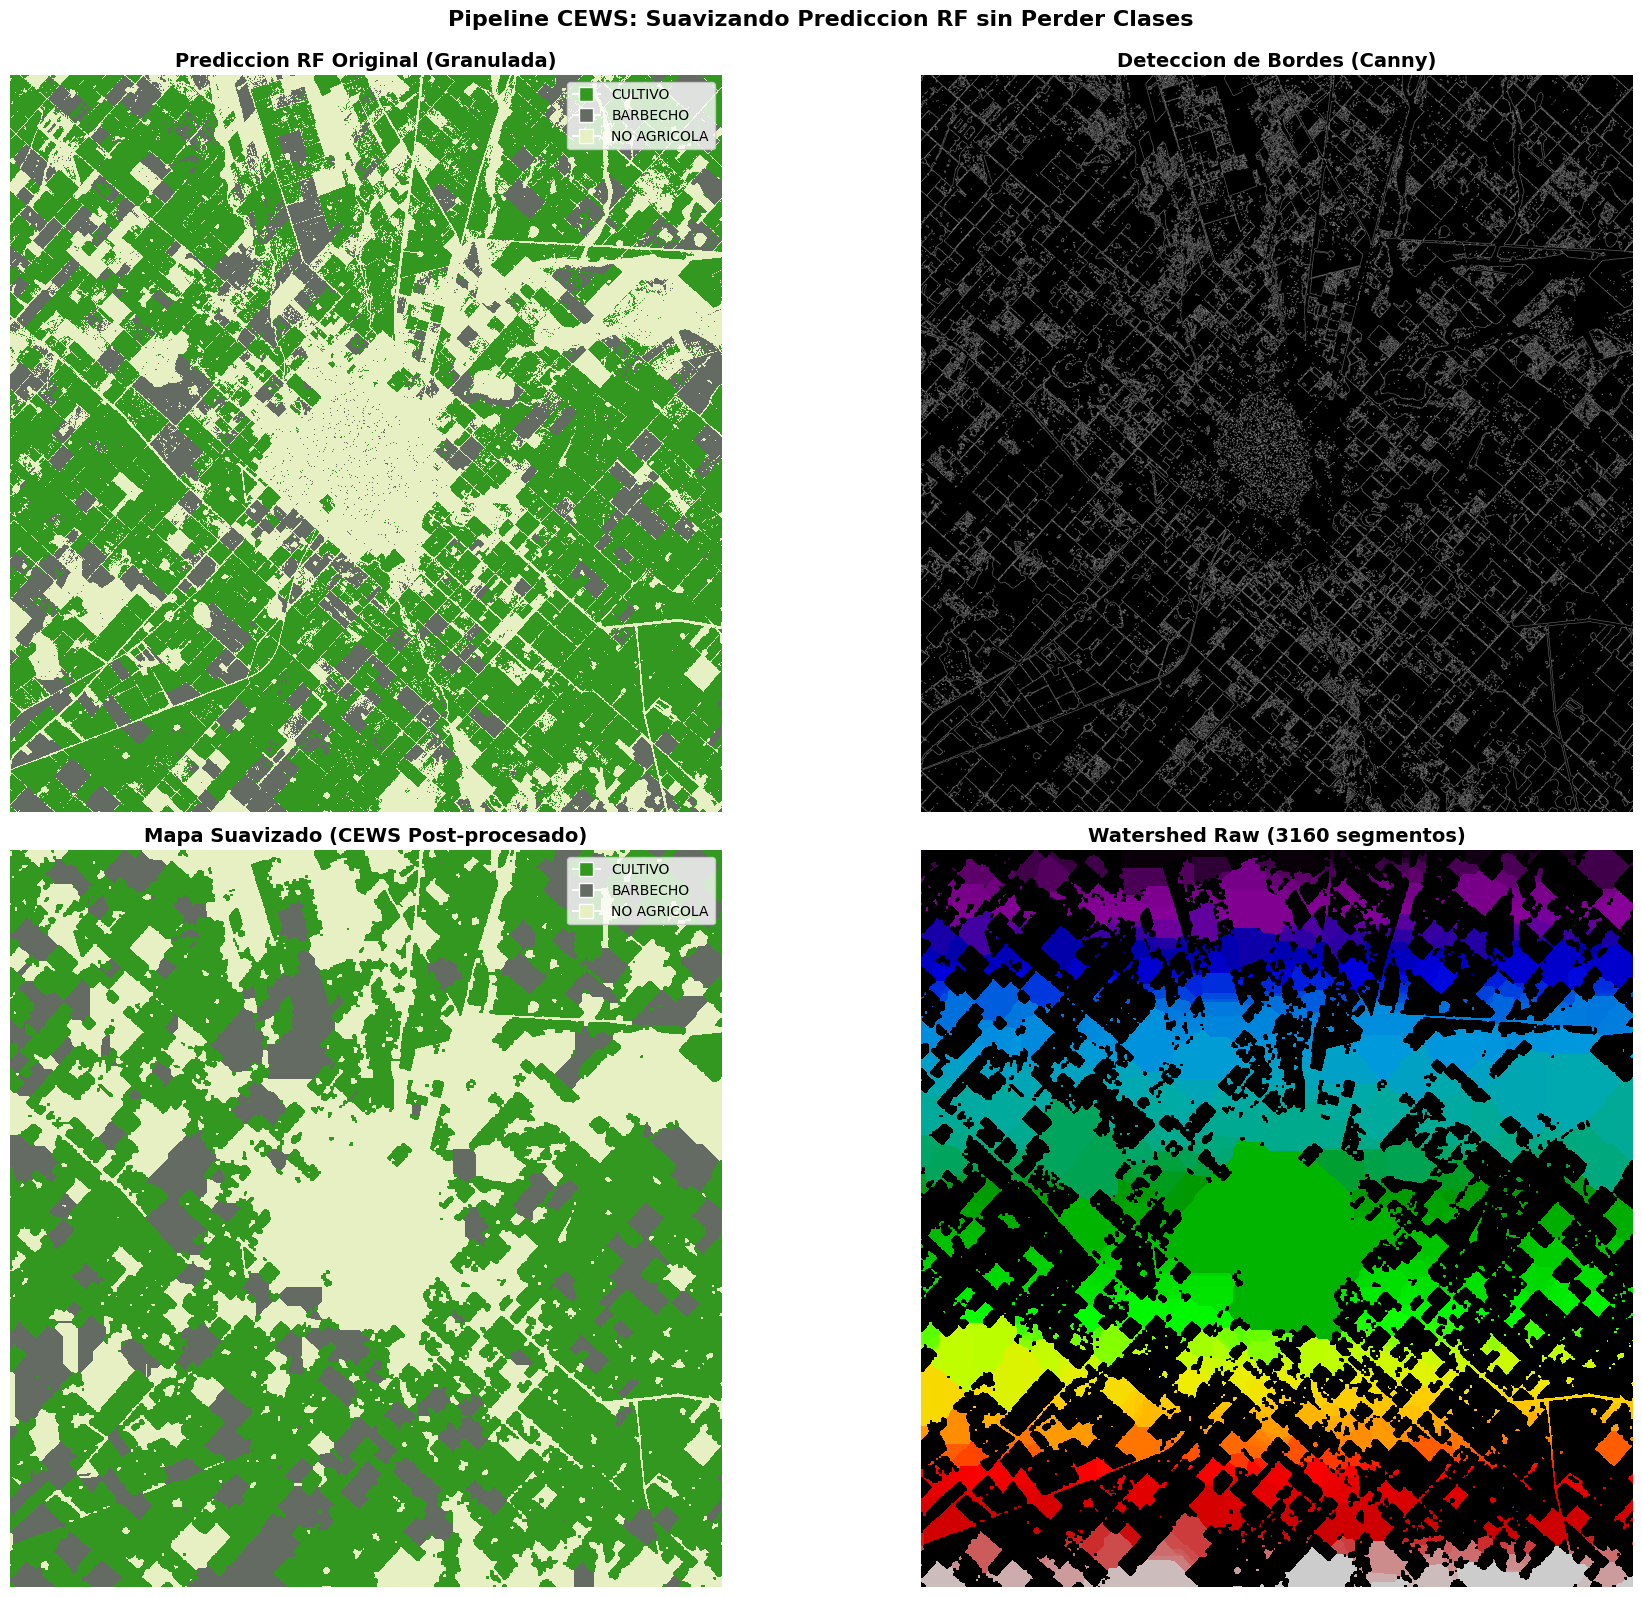


[OK] Visualizacion generada

Estadisticas del procesamiento:
  - Pixeles validos en prediccion: 8,104,712
  - Pixeles con bordes detectados (Canny): 589,598
  - Segmentos identificados (Watershed): 3160
  - Pixeles modificados por suavizado: 1,040,019 (25.30%)

Guardando mapa suavizado CEWS en: /Users/joanespada/Desktop/ADE/Recorte&Visualizacion/ade_modelo_agricola/Joan/proc_joan/11_prediccion_rf_verano_cews.tif
[OK] Mapa CEWS guardado en proc_joan


In [38]:
from cv2 import Canny, morphologyEx, MORPH_CLOSE, MORPH_OPEN
from skimage import segmentation
from scipy import ndimage
from matplotlib.colors import ListedColormap

print("="*80)
print("APLICANDO CEWS: CANNY EDGE DETECTION + WATERSHED")
print("="*80)

print("\n1. Normalizando mapa de prediccion para Canny...")
mapa_norm = np.zeros_like(mapa_prediccion, dtype=np.uint8)
mapa_valido = mapa_prediccion >= 0
mapa_norm[mapa_valido] = mapa_prediccion[mapa_valido] * 100

print("2. Aplicando Canny Edge Detection...")
edges = Canny(mapa_norm, threshold1=50, threshold2=150)

print("3. Aplicando operaciones morfologicas (cierre y apertura)...")
kernel_morph = np.ones((5, 5), np.uint8)
mapa_suavizado = morphologyEx(mapa_norm, MORPH_CLOSE, kernel_morph, iterations=2)
mapa_suavizado = morphologyEx(mapa_suavizado, MORPH_OPEN, kernel_morph, iterations=1)

print("4. Aplicando Watershed...")
mapa_distancia = ndimage.distance_transform_edt(mapa_suavizado > 50)
local_maxima = ndimage.maximum_filter(mapa_distancia, size=15) == mapa_distancia
marcadores, num_marcadores = ndimage.label(local_maxima)
mapa_watershed_raw = segmentation.watershed(-mapa_distancia, marcadores, mask=(mapa_suavizado > 50))

print(f"   Segmentos identificados: {num_marcadores}")

print("5. Remapeando segmentos a clases originales...")
mapa_suavizado_clases = np.full_like(mapa_prediccion, -1, dtype=np.int32)

for seg_id in np.unique(mapa_watershed_raw):
    if seg_id == 0:
        continue
    mascara_segmento = mapa_watershed_raw == seg_id
    clases_en_segmento = mapa_prediccion[mascara_segmento]
    clases_validas = clases_en_segmento[clases_en_segmento >= 0]
    
    if len(clases_validas) > 0:
        clase_mayoritaria = np.bincount(clases_validas.astype(int)).argmax()
        mapa_suavizado_clases[mascara_segmento] = clase_mayoritaria

print("[OK] CEWS aplicado exitosamente")

colores_clases = {
    0: '#339820',
    1: '#646b63',
    2: '#e6f0c2'
}
cmap_custom = ListedColormap([colores_clases[0], colores_clases[1], colores_clases[2]])

fig, axes = plt.subplots(2, 2, figsize=(20, 16))

ax1 = axes[0, 0]
im1 = ax1.imshow(mapa_prediccion, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax1.set_title('Prediccion RF Original (Granulada)', fontsize=14, fontweight='bold')
ax1.axis('off')
handles = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colores_clases[i], 
                       markersize=10, label=f'{["CULTIVO", "BARBECHO", "NO AGRICOLA"][i]}') 
           for i in range(3)]
ax1.legend(handles=handles, loc='upper right', fontsize=10)

ax2 = axes[0, 1]
im2 = ax2.imshow(edges, cmap='gray')
ax2.set_title('Deteccion de Bordes (Canny)', fontsize=14, fontweight='bold')
ax2.axis('off')

ax3 = axes[1, 0]
im3 = ax3.imshow(mapa_suavizado_clases, cmap=cmap_custom, vmin=0, vmax=2, interpolation='nearest')
ax3.set_title('Mapa Suavizado (CEWS Post-procesado)', fontsize=14, fontweight='bold')
ax3.axis('off')
ax3.legend(handles=handles, loc='upper right', fontsize=10)

ax4 = axes[1, 1]
im4 = ax4.imshow(mapa_watershed_raw, cmap='nipy_spectral', interpolation='nearest')
ax4.set_title(f'Watershed Raw ({num_marcadores} segmentos)', fontsize=14, fontweight='bold')
ax4.axis('off')

plt.suptitle('Pipeline CEWS: Suavizando Prediccion RF sin Perder Clases', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print(f"\n[OK] Visualizacion generada")
print(f"\nEstadisticas del procesamiento:")
print(f"  - Pixeles validos en prediccion: {np.sum(mapa_valido):,}")
print(f"  - Pixeles con bordes detectados (Canny): {np.sum(edges > 0):,}")
print(f"  - Segmentos identificados (Watershed): {num_marcadores}")

mask_cambio = (mapa_prediccion >= 0) & (mapa_suavizado_clases >= 0)
pixeles_cambiados = np.sum(mapa_prediccion[mask_cambio] != mapa_suavizado_clases[mask_cambio])
print(f"  - Pixeles modificados por suavizado: {pixeles_cambiados:,} ({100*pixeles_cambiados/np.sum(mask_cambio):.2f}%)")

# Guardar el mapa suavizado como GeoTIFF en proc_joan
os.makedirs(DATA_PROC_DIR, exist_ok=True)
output_cews_path = os.path.join(DATA_PROC_DIR, "11_prediccion_rf_verano_cews.tif")
print(f"\nGuardando mapa suavizado CEWS en: {output_cews_path}")
with rasterio.open(RASTER_PATH) as src:
    meta = src.meta.copy()
    meta.update({
        'count': 1,
        'dtype': 'int32',
        'nodata': -1
    })
    with rasterio.open(output_cews_path, 'w', **meta) as dst:
        dst.write(mapa_suavizado_clases.astype(np.int32), 1)
        dst.set_band_description(1, 'Prediccion_RF_Verano_CEWS')

print("[OK] Mapa CEWS guardado en proc_joan")
